In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator  
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.types import DoubleType

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Stock Price Prediction") \
    .getOrCreate()

In [3]:
data_pat = "/home/hadoop/Documents/historical_stock_data.csv"
print(data_pat)

/home/hadoop/Documents/historical_stock_data.csv


In [4]:
import pandas as pd
df = pd.read_csv(data_pat)
df_spark = spark.createDataFrame(df)

# Show the PySpark DataFrame
df_spark.show()

+----------+------------------+------------------+------------------+-----------------+------------------+---------+
|      Date|              Open|              High|               Low|            Close|         Adj Close|   Volume|
+----------+------------------+------------------+------------------+-----------------+------------------+---------+
|2019-01-02| 38.72249984741211|39.712501525878906|38.557498931884766|39.47999954223633| 37.75008392333984|148158800|
|2019-01-03|35.994998931884766| 36.43000030517578|              35.5|35.54750061035156| 33.98989486694336|365248800|
|2019-01-04| 36.13249969482422| 37.13750076293945| 35.95000076293945|37.06499862670898| 35.44091033935547|234428400|
|2019-01-07| 37.17499923706055| 37.20750045776367| 36.47499847412109|36.98249816894531| 35.36201477050781|219111200|
|2019-01-08| 37.38999938964844| 37.95500183105469|37.130001068115234|          37.6875|36.036128997802734|164101200|
|2019-01-09|  37.8224983215332| 38.63249969482422|37.40750122070

In [5]:
df_spark.summary()

DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]

In [8]:
df_spark.schema

StructType([StructField('Date', StringType(), True), StructField('Open', DoubleType(), True), StructField('High', DoubleType(), True), StructField('Low', DoubleType(), True), StructField('Close', DoubleType(), True), StructField('Adj Close', DoubleType(), True), StructField('Volume', LongType(), True)])

In [12]:
from pyspark.sql.types import DoubleType

# Cast the target column to double type for regression
df_spark = df_spark.withColumn(target, df_spark[target].cast(DoubleType()))


Mean Absolute Error (MAE): 1.4244889079819714


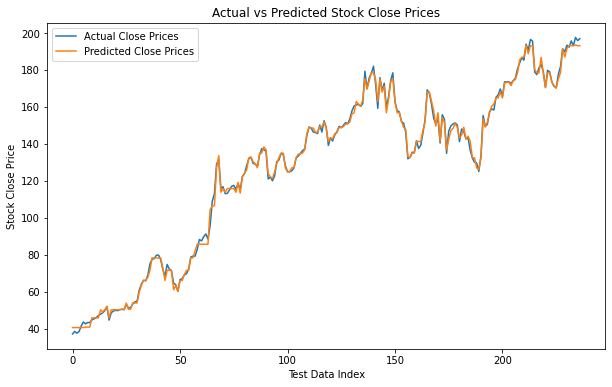

In [14]:
# Feature engineering using VectorAssembler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_spark_assembled = assembler.transform(df_spark)

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = df_spark_assembled.randomSplit([0.8, 0.2], seed=42)

# Initialize the Random Forest Regressor
from pyspark.ml.regression import RandomForestRegressor

rf_model = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=100, seed=42)

# Train the model
rf_model_fit = rf_model.fit(train_data)

# Make predictions on the test set
predictions = rf_model_fit.transform(test_data)

# Evaluate the model using RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="mae", labelCol=target, predictionCol="prediction")
mae = evaluator.evaluate(predictions)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")

# Optionally, convert predictions back to pandas DataFrame for plotting
predictions_pandas = predictions.select(target, "prediction").toPandas()

# Plot the actual vs predicted Close prices (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions_pandas[target].values, label='Actual Close Prices')
plt.plot(predictions_pandas['prediction'], label='Predicted Close Prices')
plt.title('Actual vs Predicted Stock Close Prices')
plt.xlabel('Test Data Index')
plt.ylabel('Stock Close Price')
plt.legend()
plt.show()

# Stop Spark session
spark.stop()
